## Inference under FHE for the MNIST Dataset using helayers

In this demo, we'll deal with a classification problem for the MNIST dataset [1], trying to correctly classify a batch of samples using a neural network model that will be created and trained using the Keras library (with architecture similar to reference [2]).
First, we'll build a plain neural network for the MNIST model. Then, we'll encrypt the trained network and run inference over it using FHE.

In [1]:
import os

##### For reproducibility
seed_value= 1
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
from tensorflow.keras import backend as K

from tensorflow.keras import utils, losses
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
import h5py

# import activations
import sys
sys.path.append(os.path.join('.', 'data_gen'))
from activations import SquareActivation

PATH = os.path.join('data', 'net_mnist')
if not os.path.exists(PATH):
    os.makedirs(PATH)

batch_size = 500
epochs = 10
print("Misc. initializations")

2025-04-23 08:50:31.613263: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 08:50:31.657867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 08:50:31.968945: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 08:50:31.971070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-23 08:50:33.268896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Misc. initializations


### Load and Preprocess the MNIST Dataset. 

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train /= 255
x_test /= 255
print('data ready')

# Image padding
x_train = np.pad(x_train, ((0, 0), (0, 1), (0, 1), (0, 0)))
x_test = np.pad(x_test, ((0, 0), (0, 1), (0, 1), (0, 0)))
print('Added padding. New shape: ',x_train.shape)

data ready
Added padding. New shape:  (60000, 29, 29, 1)


In [3]:
# Create validation data
testSize=16
x_val = x_test[:-testSize]
x_test = x_test[-testSize:]
y_val = y_test[:-testSize]
y_test = y_test[-testSize:]
print('Validation and test data ready')

# Convert class vector to binary class matrices
num_classes = 10
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)
y_val = utils.to_categorical(y_val, num_classes)

input_shape = x_train[0].shape
print(f'input shape: {input_shape}')

Validation and test data ready
input shape: (29, 29, 1)


### Save Dataset

In [4]:
def save_data_set(x, y, data_type, s=''):
    fname=os.path.join(PATH, f'x_{data_type}{s}.h5')
    print("Saving x_{} of shape {} in {}".format(data_type, x.shape,fname))
    xf = h5py.File(fname, 'w')
    xf.create_dataset('x_{}'.format(data_type), data=x)
    xf.close()

    yf = h5py.File(os.path.join(PATH, f'y_{data_type}{s}.h5'), 'w')
    yf.create_dataset(f'y_{data_type}', data=y)
    yf.close()

save_data_set(x_test, y_test, data_type='test')
save_data_set(x_train, y_train, data_type='train')
save_data_set(x_val, y_val, data_type='val')

Saving x_test of shape (16, 29, 29, 1) in data/net_mnist/x_test.h5
Saving x_train of shape (60000, 29, 29, 1) in data/net_mnist/x_train.h5
Saving x_val of shape (9984, 29, 29, 1) in data/net_mnist/x_val.h5


### Build a Plain Neural Network for the MNIST Model

In [5]:
model = Sequential()
model.add(Conv2D(filters=5, kernel_size=5, strides=2, padding='valid',
                 input_shape=input_shape))
model.add(Flatten())
model.add(SquareActivation())
model.add(Dense(100))
model.add(SquareActivation())
model.add(Dense(num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 13, 5)         130       
                                                                 
 flatten (Flatten)           (None, 845)               0         
                                                                 
 square_activation (SquareA  (None, 845)               0         
 ctivation)                                                      
                                                                 
 dense (Dense)               (None, 100)               84600     
                                                                 
 square_activation_1 (Squar  (None, 100)               0         
 eActivation)                                                    
                                                                 
 dense_1 (Dense)             (None, 10)                1

### Train the Neural Network

In [6]:
def sum_squared_error(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true), axis=-1)

model.compile(loss=sum_squared_error,
                  optimizer='Adam',
                  metrics=['accuracy'])

model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=2,
              validation_data=(x_val, y_val),
              shuffle=True,
              )

score = model.evaluate(x_test, y_test, verbose=0)

print(f'Test loss: { score[0]:.3f}')
print(f'Test accuracy: {score[1] * 100:.3f}%')

Epoch 1/10
120/120 - 2s - loss: 0.3931 - accuracy: 0.8425 - val_loss: 0.2056 - val_accuracy: 0.9550 - 2s/epoch - 13ms/step
Epoch 2/10
120/120 - 1s - loss: 0.1774 - accuracy: 0.9594 - val_loss: 0.1477 - val_accuracy: 0.9685 - 925ms/epoch - 8ms/step
Epoch 3/10
120/120 - 1s - loss: 0.1390 - accuracy: 0.9701 - val_loss: 0.1267 - val_accuracy: 0.9749 - 861ms/epoch - 7ms/step
Epoch 4/10
120/120 - 1s - loss: 0.1201 - accuracy: 0.9754 - val_loss: 0.1130 - val_accuracy: 0.9775 - 880ms/epoch - 7ms/step
Epoch 5/10
120/120 - 1s - loss: 0.1083 - accuracy: 0.9790 - val_loss: 0.1049 - val_accuracy: 0.9793 - 895ms/epoch - 7ms/step
Epoch 6/10
120/120 - 1s - loss: 0.1000 - accuracy: 0.9810 - val_loss: 0.0983 - val_accuracy: 0.9807 - 871ms/epoch - 7ms/step
Epoch 7/10
120/120 - 1s - loss: 0.0937 - accuracy: 0.9833 - val_loss: 0.0942 - val_accuracy: 0.9819 - 926ms/epoch - 8ms/step
Epoch 8/10
120/120 - 1s - loss: 0.0890 - accuracy: 0.9842 - val_loss: 0.0914 - val_accuracy: 0.9819 - 926ms/epoch - 8ms/step
Ep

### Report the Confusion Matrix of the Trained Model

In [7]:
from sklearn import metrics

y_pred_vals = model.predict(x_test)
y_pred = np.argmax(y_pred_vals, axis=1)
y_test = np.argmax(y_test, axis=1)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

1/1 [==============================] - 0s 51ms/step
[[1 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]


In [8]:
from sklearn import metrics

y_pred_vals = model.predict(x_val)
y_pred_max = np.argmax(y_pred_vals, axis=1)
y_val_max = np.argmax(y_val, axis=1)
cm = metrics.confusion_matrix(y_val_max, y_pred_max)
print(cm)

312/312 [==============================] - 1s 2ms/step
[[ 971    1    4    0    1    0    0    1    1    0]
 [   0 1124    3    1    1    1    1    1    1    0]
 [   3    0 1017    0    0    0    1    5    3    1]
 [   0    0    5  991    0    4    0    4    4    0]
 [   1    0    0    0  964    0    4    1    2    8]
 [   2    1    0    5    0  877    3    1    1    0]
 [   5    3    0    1    1    4  939    1    2    0]
 [   0   10   11    0    1    1    0 1000    1    3]
 [   2    0    2    3    0    2    0    3  959    2]
 [   2    2    1    3   10    3    0    7    5  975]]


1/1 [==============================] - 0s 19ms/step


  0%|          | 0/2 [00:00<?, ?it/s]

32/32 [==============================] - 0s 1ms/step


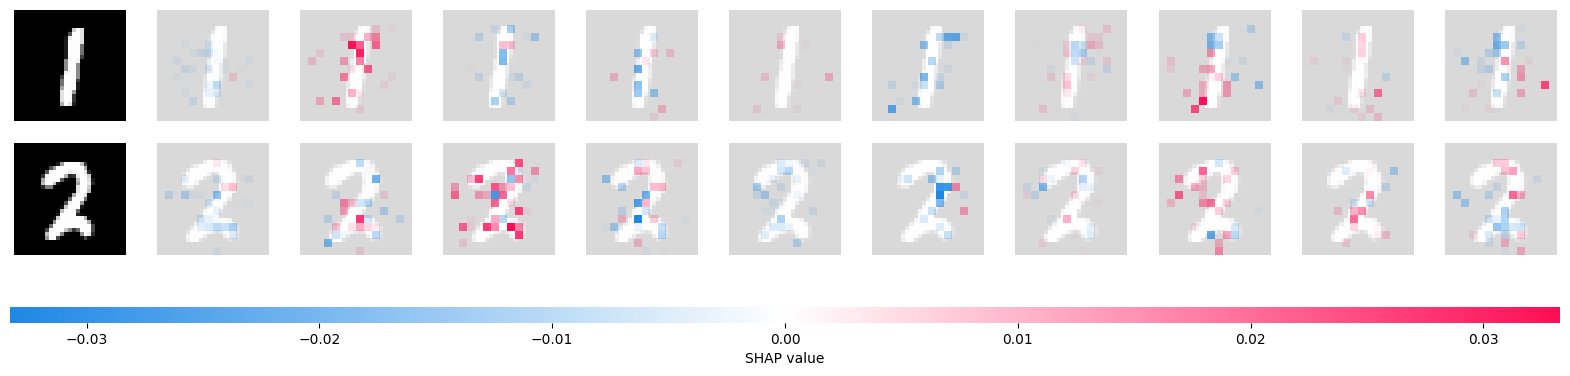

SHAP explainability completed successfully!


In [14]:
import numpy as np
import shap
import tensorflow as tf
import matplotlib.pyplot as plt

# ---- Dimensionality Reduction with Pooling ----
def reduce_with_pooling(images, pool_size=2):
    """
    Reduce the feature space using average pooling to downsample images.
    """
    reduced_images = tf.nn.avg_pool(
        images,
        ksize=(1, pool_size, pool_size, 1),
        strides=(1, pool_size, pool_size, 1),
        padding='VALID'
    )
    return reduced_images.numpy()

# Apply pooling to reduce dimensions for both background and test samples
pool_size = 2  # Pooling factor
background_reduced = reduce_with_pooling(x_train[:10])  # First 10 training images as background
x_test_reduced = reduce_with_pooling(x_test[:2])  # First 2 test samples for explanation

# Flatten the pooled images for SHAP compatibility
background_flattened = background_reduced.reshape((background_reduced.shape[0], -1))
x_test_flattened = x_test_reduced.reshape((x_test_reduced.shape[0], -1))

# ---- Define Prediction Function ----
def predict_fn(data):
    """
    Map reduced representations back to the full-size input for predictions.
    """
    full_images = tf.image.resize(tf.convert_to_tensor(data.reshape((-1, *background_reduced.shape[1:]))), (29, 29))
    return model.predict(full_images.numpy())

# ---- Initialize SHAP KernelExplainer ----
explainer = shap.KernelExplainer(predict_fn, background_flattened)

# ---- Compute SHAP Values ----
shap_values = explainer.shap_values(x_test_flattened, nsamples=100)  # Limit to 100 perturbations

# ---- Adjust SHAP Visualization ----
# Reshape SHAP values to match the original image dimensions (if needed)
shap_values_reshaped = [value.reshape((-1, *background_reduced.shape[1:])) for value in shap_values]

# Visualize SHAP explanations with properly structured data
shap.image_plot(shap_values_reshaped, x_test[:2])  # Match test samples with SHAP values

# Save SHAP values if needed
np.save('shap_values.npy', shap_values)

print("SHAP explainability completed successfully!")


The presence of 10 SHAP plots (or columns) per sample corresponds to the 10 output classes of the model, since your model is trained on the MNIST dataset, which has 10 possible digit classes (0 through 9).

Here's what each column represents:

1. SHAP Values for Each Class
Each column shows the SHAP explanation for how the features (pixels) contribute to the probability of the corresponding digit class. For example:

The first column explains the contribution of the image's pixels to the model's probability for the digit "0."

The second column does the same for the probability of the digit "1."

This continues up to the last column, which explains the contribution of the pixels to the probability of the digit "9."

2. Interpretation for Each Column
Red Areas: These pixels increase the probability for the respective digit class.

Blue Areas: These pixels decrease the probability for the respective digit class.

The magnitude of the red or blue colors indicates the strength of the contribution (positive or negative) to the specific class.

3. Why Are There 10 Columns per Sample?
The model outputs a probability distribution over all 10 classes for each input image. The SHAP framework calculates feature contributions for each class independently, even though the predicted class might be just one of them.

For example:

If the sample is an image of the digit "1," you might see:

Strong red contributions in the second column (digit "1"), as the relevant pixels reinforce this prediction.

Predominantly blue contributions in other columns (e.g., "0," "2," etc.), showing how the same pixels decrease the probability of those other classes.

Takeaway
The 10 plots provide a holistic view of how the model interprets an image across all possible classes. This helps you verify whether the model is confidently focusing on relevant features for the correct class, while also checking if it mistakenly assigns probabilities to irrelevant classes.

### Serialize Model and Weights

In [21]:
model_json = model.to_json()
with open(os.path.join(PATH, 'model.json'), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join(PATH, 'model.h5'))
print("Saved model to disk")

Saved model to disk


We are all done training the plain network. Next we will encrypt the network and run inference over it using FHE. Let's start with some initializations.

In [22]:
import pyhelayers
import utils

utils.verify_memory()

print('Misc. initializations')

Misc. initializations


The following is a general outline of the next steps.

We encode and encrypt a neural network model, using the files that were created and saved before. An automated optimizer, that occurs during the call to encode_encrypt, will examine our network and will determine various configuration details that will allow running inference under encryption efficiently.

Next, we will demonstrate how we can encrypt data, run inference on our encrypted network, and compare the results against the expected labels.
Now let's dive in . . .

In [23]:
he_run_req = pyhelayers.HeRunRequirements()
he_run_req.set_he_context_options([pyhelayers.DefaultContext()])
he_run_req.optimize_for_batch_size(16)

nn = pyhelayers.NeuralNet()
nn.encode_encrypt([os.path.join(PATH, "model.json"), os.path.join(PATH, "model.h5")], he_run_req)

The encode_encrypt method also initialized an HeContext object containing the keys. We obtain it now from the model so we can encrypt the input data.

In [24]:
context = nn.get_created_he_context()

We will now load real samples of the MNIST dataset to classify. We will load the samples and the corresponding true labels from HDF5 files. We will also extract the first batch of samples and labels.

In [25]:
with h5py.File(os.path.join(PATH, "x_test.h5")) as f:
    x_test = np.array(f["x_test"])
with h5py.File(os.path.join(PATH, "y_test.h5")) as f:
    y_test = np.array(f["y_test"])
    
plain_samples, labels = utils.extract_batch(x_test, y_test, batch_size, 0)

print('Batch of size',batch_size,'loaded')

Batch of size 500 loaded


To populate the input, we need to encode and then encrypt the values of the plain input under HE.

In [26]:
model_io_encoder = pyhelayers.ModelIoEncoder(nn)
samples = pyhelayers.EncryptedData(context)
model_io_encoder.encode_encrypt(samples, [plain_samples])
print('Test data encrypted')

Test data encrypted


We now go ahead with the inference itself. We run the encrypted input through the encrypted NN to obtain encrypted results. This computation does not use the secret key and acts on completely encrypted values. Running the inference is done using the "predict" method of the NN, that receives the destination 3D structure to put the result of the computation in, and the input for the inference.

In [21]:
utils.start_timer()

predictions = pyhelayers.EncryptedData(context)
nn.predict(predictions, samples)

duration=utils.end_timer('predict')
utils.report_duration('predict per sample',duration/batch_size)

Duration of predict: 0.906 (s)
Duration of predict per sample: 0.002 (s)


In order to assess the results of the computation, we first need to decrypt them. This is done by an IO processor that has the secret key and is capable of decrypting the ciphertext and decoding it into plaintext version of the HE computation result.

In [22]:
plain_predictions = model_io_encoder.decrypt_decode_output(predictions)
print('predictions',plain_predictions)

predictions [[ 0.01508655  0.9556766  -0.03254654 -0.0498449  -0.02826862 -0.03830043
   0.03392333  0.12958999  0.03242511 -0.04932714]
 [-0.02009235  0.07079617  0.81363009  0.08180354 -0.07353853 -0.06460142
   0.075831    0.20277292  0.0717024  -0.12123238]
 [-0.02696569 -0.01127931 -0.02921735  0.94552477  0.03677153  0.01486113
   0.02564035 -0.04214175  0.01752971  0.06823581]
 [-0.0211434  -0.03980317  0.00716084  0.00199379  1.12982181 -0.04549023
   0.00759635 -0.02203351 -0.03035469  0.00329346]
 [-0.0122534   0.03895842  0.01073258 -0.09541493 -0.01397666  1.0175656
   0.04253887  0.02883085 -0.02768353 -0.05722819]
 [-0.02556069 -0.01277226  0.02841343 -0.03513888 -0.01457178  0.03727296
   1.03760964 -0.01876368  0.01511617 -0.00418618]
 [-0.03429304 -0.00731335 -0.02504475 -0.00593381 -0.01856585 -0.009705
   0.0330103   1.05247671  0.01809032  0.04164397]
 [ 0.02558459  0.07087585  0.00838081 -0.06852435  0.20419284  0.01208903
  -0.00149254 -0.11654867  0.8952453  -0.1

Now we compare the results against the expected labels and compute the confusion matrix and the accuracy.

In [23]:
utils.assess_results(labels, plain_predictions)


Confusion Matrix:
[[1 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]


1.0

In [36]:
import os
import numpy as np
import pyhelayers
import utils          # from your existing FHE setup
import tensorflow as tf  # for resizing

# Verify memory and initialize FHE context
utils.verify_memory()
print('Initializing homomorphic encryption for SHAP values...')

he_run_req = pyhelayers.HeRunRequirements()
he_run_req.set_he_context_options([pyhelayers.DefaultContext()])
he_run_req.optimize_for_batch_size(16)

# Initialize and encrypt the neural network model
nn = pyhelayers.NeuralNet()
nn.encode_encrypt([os.path.join(PATH, "model.json"), os.path.join(PATH, "model.h5")], he_run_req)
context = nn.get_created_he_context()

# ---------------------------------------------------------------------------
# Assume you have computed your SHAP values already.
# shap_values_reshaped is a list of 10 arrays (one per class) where each array
# has shape (n_samples, h, w, 1). In your case the intermediate shape is (n_samples, 14, 14, 1).
# ---------------------------------------------------------------------------

# Combine the 10 outputs into one by averaging over the class axis.
combined_shap_values = np.mean(np.array(shap_values_reshaped), axis=0)
print("Shape of combined SHAP values before resizing:", combined_shap_values.shape)
# For example, (n_samples, 14, 14, 1)

# Your FHE model expects inputs of shape (-1, 29, 29, 1) so resize if necessary:
expected_shape = (29, 29)
if combined_shap_values.shape[1:3] != expected_shape:
    # Resize the images to match expected dimensions (using bilinear interpolation)
    combined_shap_values = tf.image.resize(combined_shap_values, expected_shape,
                                           method=tf.image.ResizeMethod.BILINEAR).numpy()

print("Shape of combined SHAP values after resizing:", combined_shap_values.shape)
# Now should be (n_samples, 29, 29, 1)

# Prepare the EncryptedData object and the Model I/O encoder.
shap_encrypted = pyhelayers.EncryptedData(context)
shap_io_encoder = pyhelayers.ModelIoEncoder(nn)

# Encrypt the combined SHAP values.
# The encoder expects a list with one numpy array matching the network’s input shape.
shap_io_encoder.encode_encrypt(shap_encrypted, [combined_shap_values])
print('SHAP values encrypted successfully.')

# ---------------------------------------------------------------------------
# Verification: Instead of decrypting the raw encrypted input, 
# perform a forward pass through the encrypted neural network.
# This simulates the normal FHE workflow.
# ---------------------------------------------------------------------------

# Create an EncryptedData object to hold the network's output.
encrypted_output = pyhelayers.EncryptedData(context)

# Pass the encrypted SHAP values through the network's prediction routine.
nn.predict(encrypted_output, shap_encrypted)

# Decrypt and decode the network's output.
decrypted_output = shap_io_encoder.decrypt_decode_output(encrypted_output)
print('Decrypted network predictions from encrypted SHAP values:', decrypted_output)

# Note:
# These predictions correspond to the neural network's output for the given SHAP values.
# They may not be interpretable as "SHAP values" since the network's forward path was applied.


Initializing homomorphic encryption for SHAP values...
Shape of combined SHAP values before resizing: (2, 14, 14, 1)
Shape of combined SHAP values after resizing: (2, 29, 29, 1)
SHAP values encrypted successfully.
Decrypted network predictions from encrypted SHAP values: [[ 0.03924931  0.30495556  0.11677175  0.08060453  0.02740902  0.40723772
   0.03024192  0.14935137 -0.11697674 -0.01308532]
 [ 0.03958081  0.30490711  0.11654149  0.08044238  0.02735919  0.40732359
   0.03000222  0.14937533 -0.11687706 -0.01298974]]


In our FHE framework the method decrypt_decode_output() is designed to decrypt the output of the neural network’s forward pass, not an encrypted input. (When you encrypt your training or test data you later call the network’s predict routine and then decrypt its output.)

To verify (i.e. to do a “round‐trip”) that your encryption works correctly, you should run a forward pass on your encrypted SHAP values through your (FHE‑encrypted) neural network, then decrypt the network’s output. (Note—the decrypted output will be the network’s prediction when given SHAP values as input; it won’t be the original SHAP values, but it will verify that encryption and evaluation are working.)

Below is the modified code for verification that replaces the direct decryption of the input with a call to the network’s predict method before decryption:

In [37]:
import os
import numpy as np
import pyhelayers
import utils           # Your helper module from the FHE setup
import tensorflow as tf  # Used for resizing

# Assume PATH is set and points to the folder with model.json and model.h5.
# Also assume shap_values_reshaped is already computed: a list of 10 arrays (one per class)
# For instance: shap_values_reshaped = [shap_class0, shap_class1, ..., shap_class9]

# ------------------------------------------------------------------------------
# 1. Initialize and Encrypt Neural Network Model (FHE Setup)
# ------------------------------------------------------------------------------
utils.verify_memory()
print("Initializing homomorphic encryption for SHAP values...")

he_run_req = pyhelayers.HeRunRequirements()
he_run_req.set_he_context_options([pyhelayers.DefaultContext()])
he_run_req.optimize_for_batch_size(16)

nn = pyhelayers.NeuralNet()
nn.encode_encrypt([os.path.join(PATH, "model.json"), os.path.join(PATH, "model.h5")], he_run_req)
context = nn.get_created_he_context()

# ------------------------------------------------------------------------------
# 2. Process SHAP Values to Match Network Input Requirements
# ------------------------------------------------------------------------------
# Combine the 10 per-class SHAP outputs by averaging over the class axis.
combined_shap_values = np.mean(np.array(shap_values_reshaped), axis=0)
print("Shape of combined SHAP values before resizing:", combined_shap_values.shape)
# (For example, this may print: (n_samples, 14, 14, 1))

# The network expects its input to be shaped as (-1, 29, 29, 1).
expected_spatial_dims = (29, 29)
if combined_shap_values.shape[1:3] != expected_spatial_dims:
    combined_shap_values = tf.image.resize(combined_shap_values, expected_spatial_dims,
                                           method=tf.image.ResizeMethod.BILINEAR).numpy()
print("Shape of combined SHAP values after resizing:", combined_shap_values.shape)
# Now, should be: (n_samples, 29, 29, 1)

# ------------------------------------------------------------------------------
# 3. Encrypt the Combined SHAP Values 
# ------------------------------------------------------------------------------
# Create an EncryptedData object and use the ModelIoEncoder to encrypt.
shap_encrypted = pyhelayers.EncryptedData(context)
shap_io_encoder = pyhelayers.ModelIoEncoder(nn)

# The encoder expects a list with exactly one NumPy array (matching the network input)
shap_io_encoder.encode_encrypt(shap_encrypted, [combined_shap_values])
print("SHAP values encrypted successfully.")

# ------------------------------------------------------------------------------
# 4. Verification: Run Encrypted Inference and Decrypt the Output
# ------------------------------------------------------------------------------
# Instead of decrypting the raw input, perform a forward encrypted inference.
encrypted_output = pyhelayers.EncryptedData(context)

print("Running encrypted inference on the SHAP values...")
nn.predict(encrypted_output, shap_encrypted)

# Decrypt and decode the network's predictions.
decrypted_output = shap_io_encoder.decrypt_decode_output(encrypted_output)
print("Decrypted network predictions from encrypted SHAP values:")
print(decrypted_output)

# ------------------------------------------------------------------------------
# Note:
# The decrypted_output gives you the network's output (predictions) when provided with
# the encrypted SHAP values as input. This round-trip verifies that the encryption,
# network evaluation, and decryption steps are functioning as expected.
# ------------------------------------------------------------------------------


Initializing homomorphic encryption for SHAP values...
Shape of combined SHAP values before resizing: (2, 14, 14, 1)
Shape of combined SHAP values after resizing: (2, 29, 29, 1)
SHAP values encrypted successfully.
Running encrypted inference on the SHAP values...
Decrypted network predictions from encrypted SHAP values:
[[ 0.03924931  0.30495556  0.11677175  0.08060453  0.02740902  0.40723772
   0.03024192  0.14935137 -0.11697674 -0.01308532]
 [ 0.03958081  0.30490711  0.11654149  0.08044238  0.02735919  0.40732359
   0.03000222  0.14937533 -0.11687706 -0.01298974]]



Plaintext Predictions: These are obtained by running your original Keras model on the combined SHAP values in cleartext. They represent how the model "sees" the explanation information from the SHAP values.

FHE Predictions: These are obtained by encrypting the same combined SHAP values, running them through your FHE-encrypted model, and then decrypting the output. The FHE process is designed to yield (within a small numerical margin due to approximations) the same output as the plaintext inference.

Comparing Predictions: By comparing the two sets of predictions (e.g., via an absolute difference), you can verify that the FHE pipeline preserves the essential explanatory information contained in the SHAP values. In an ideal scenario, the predictions should be nearly identical (perhaps differing only in small numerical precision or rounding).

Regarding the Explanation: Ultimately, if the FHE and plaintext predictions agree, then you have confidence that applying FHE to your SHAP values retains the same information. You could then use the decrypted FHE inference as an indicator of how the SHAP values support a given class. For instance, if—for a particular sample—the highest score in both plaintext and FHE predictions corresponds to the same class, you can assert that the FHE process correctly preserves the model’s explanation properties.

This code, and its comparison of plaintext versus FHE predictions, fulfills the objective of checking that the encrypted SHAP values preserve the same information as the original SHAP values.

In [38]:
import os
import numpy as np
import pyhelayers
import utils                # Your helper module from the FHE setup
import tensorflow as tf     # For resizing

# ---------------------------------------------------------------------------
# 1. Load/Define your combined SHAP values (from your SHAP explainability)
#    Here we assume shap_values_reshaped is a list of 10 arrays (one per class)
#    with shape (n_samples, 14, 14, 1). We combine them by averaging and resize.
# ---------------------------------------------------------------------------
combined_shap_values = np.mean(np.array(shap_values_reshaped), axis=0)
print("Shape of combined SHAP values before resizing:", combined_shap_values.shape)
expected_spatial_dims = (29, 29)
if combined_shap_values.shape[1:3] != expected_spatial_dims:
    combined_shap_values = tf.image.resize(combined_shap_values, expected_spatial_dims,
                                           method=tf.image.ResizeMethod.BILINEAR).numpy()
print("Shape of combined SHAP values after resizing:", combined_shap_values.shape)
# Now combined_shap_values has shape (n_samples, 29, 29, 1)

# ---------------------------------------------------------------------------
# 2. Obtain Plaintext Predictions (Reference)
# ---------------------------------------------------------------------------
# (Assuming your original plain Keras model is available as 'model')
plaintext_predictions = model.predict(combined_shap_values)
print("Plaintext predictions from combined SHAP values:")
print(plaintext_predictions)
# These predictions are what you would get if you fed the combined SHAP values to your model in the clear.

# ---------------------------------------------------------------------------
# 3. Set Up the FHE Environment and Encrypt the Combined SHAP Values
# ---------------------------------------------------------------------------
utils.verify_memory()
print("Initializing homomorphic encryption for SHAP values...")

he_run_req = pyhelayers.HeRunRequirements()
he_run_req.set_he_context_options([pyhelayers.DefaultContext()])
he_run_req.optimize_for_batch_size(16)

# Initialize and encrypt the neural network model from FHE files.
nn = pyhelayers.NeuralNet()
nn.encode_encrypt([os.path.join(PATH, "model.json"), os.path.join(PATH, "model.h5")], he_run_req)
context = nn.get_created_he_context()

# Create an EncryptedData object for the input and a ModelIoEncoder.
shap_encrypted = pyhelayers.EncryptedData(context)
shap_io_encoder = pyhelayers.ModelIoEncoder(nn)

# Encrypt the combined SHAP values. 
# Note: The encoder expects a [numpy array] that matches the network's input shape.
shap_io_encoder.encode_encrypt(shap_encrypted, [combined_shap_values])
print("SHAP values encrypted successfully.")

# ---------------------------------------------------------------------------
# 4. Run Encrypted Inference and Decrypt the Prediction Output
# ---------------------------------------------------------------------------
encrypted_output = pyhelayers.EncryptedData(context)
print("Running encrypted inference on the combined SHAP values...")
nn.predict(encrypted_output, shap_encrypted)

# Decrypt and decode the network's output.
fhe_predictions = shap_io_encoder.decrypt_decode_output(encrypted_output)
print("FHE predictions (decrypted) from combined SHAP values:")
print(fhe_predictions)

# ---------------------------------------------------------------------------
# 5. Compare the Results
# ---------------------------------------------------------------------------
difference = np.abs(plaintext_predictions - fhe_predictions)
print("Difference between plaintext and FHE predictions:")
print(difference)

# Optionally, you could compute aggregate statistics like maximum difference:
max_diff = np.max(difference)
print("Maximum difference:", max_diff)


Shape of combined SHAP values before resizing: (2, 14, 14, 1)
Shape of combined SHAP values after resizing: (2, 29, 29, 1)
1/1 [==============================] - 0s 52ms/step
Plaintext predictions from combined SHAP values:
[[ 0.03924934  0.3049555   0.11677174  0.08060454  0.027409    0.40723768
   0.03024194  0.14935136 -0.11697674 -0.01308529]
 [ 0.03958081  0.30490708  0.1165415   0.08044241  0.0273592   0.40732357
   0.0300022   0.14937532 -0.11687708 -0.01298973]]
Initializing homomorphic encryption for SHAP values...
SHAP values encrypted successfully.
Running encrypted inference on the combined SHAP values...
FHE predictions (decrypted) from combined SHAP values:
[[ 0.0392493   0.30495556  0.11677175  0.08060453  0.02740902  0.40723772
   0.03024192  0.14935137 -0.11697674 -0.01308532]
 [ 0.03958081  0.30490711  0.1165415   0.08044239  0.02735919  0.40732359
   0.03000222  0.14937533 -0.11687706 -0.01298974]]
Difference between plaintext and FHE predictions:
[[3.78212395e-08 4.

Below is one integrated code example that meets the following objective:

Build a SHAP explainer on plain training data (background) using your plain x_train.

Define two prediction functions for your neural network:

A plain prediction function (using your unencrypted model).

An FHE prediction function that encrypts incoming data using pyhelayers (with your previously built FHE model), runs encrypted inference, then decrypts the result.

Use the same SHAP explainer framework (here we use KernelExplainer for illustration) with both prediction functions on a (small) set of x_test samples.

Compare the “raw” SHAP values obtained in the clear (plain) with those computed via the FHE‐encrypted pathway (which you decrypt to recover the SHAP values).

In effect, you verify that applying FHE to the “explanation” (via the prediction function inside SHAP) “preserves” the information encoded in the SHAP values.

Below is the complete code. (Adjust paths, nsamples, and sample counts as needed.)

In [ ]:
import os
import numpy as np
import tensorflow as tf
import shap
import pyhelayers
import utils  # Your helper module for FHE setup

# -----------------------------------------------------------------------------
# 1. Data Preparation
# -----------------------------------------------------------------------------
# For KernelExplainer to work reliably, the number of background samples must
# exceed the number of features. Since each image (29,29,1) flattens to 841 features,
# we choose a background size of 1000 samples (or any number >>841).
background = x_train[:1000]       # shape: (1000, 29, 29, 1)
x_test_small = x_test[:2]         # shape: (2, 29, 29, 1)

# Flatten images to 1D (KernelExplainer requires 1D or 2D input).
background_flat = background.reshape((background.shape[0], -1))  # shape: (1000, 841)
x_test_small_flat = x_test_small.reshape((x_test_small.shape[0], -1))  # shape: (2, 841)

# -----------------------------------------------------------------------------
# 2. Define Prediction Functions that work on flattened input
# -----------------------------------------------------------------------------
def plain_predict_flat(flat_data):
    """
    Takes flattened inputs (n_samples, 841), reshapes to (-1,29,29,1),
    and returns predictions from the plain model.
    """
    reshaped = flat_data.reshape(-1, 29, 29, 1)
    return model.predict(reshaped)

# Initialize FHE components for encrypted inference
utils.verify_memory()
print("Initializing FHE for prediction...")
he_run_req = pyhelayers.HeRunRequirements()
he_run_req.set_he_context_options([pyhelayers.DefaultContext()])
he_run_req.optimize_for_batch_size(16)

nn = pyhelayers.NeuralNet()
nn.encode_encrypt([os.path.join(PATH, "model.json"), os.path.join(PATH, "model.h5")],
                  he_run_req)
context = nn.get_created_he_context()
shap_io_encoder = pyhelayers.ModelIoEncoder(nn)

def fhe_predict_flat(flat_data):
    """
    Takes flattened input (n_samples, 841), reshapes to (-1,29,29,1),
    encrypts it, runs FHE inference, decrypts output, and returns predictions.
    """
    reshaped = flat_data.reshape(-1, 29, 29, 1)
    # Encrypt the input.
    encrypted_input = pyhelayers.EncryptedData(context)
    shap_io_encoder.encode_encrypt(encrypted_input, [reshaped])
    
    # Perform encrypted prediction.
    encrypted_output = pyhelayers.EncryptedData(context)
    nn.predict(encrypted_output, encrypted_input)
    
    # Decrypt the output.
    decrypted_result = shap_io_encoder.decrypt_decode_output(encrypted_output)
    return decrypted_result

# -----------------------------------------------------------------------------
# 3. Build SHAP Explainers Using the Flattened Background
# -----------------------------------------------------------------------------
# Setting l1_reg to a fixed constant (e.g. 0.001) avoids the default noise variance
# estimation that causes the under-determined error when background size is small.
l1_reg_constant = 0.001

explainer_plain = shap.KernelExplainer(plain_predict_flat, background_flat, l1_reg=l1_reg_constant)
explainer_fhe   = shap.KernelExplainer(fhe_predict_flat, background_flat,   l1_reg=l1_reg_constant)

# Choose a modest number of samples for perturbations.
nsamples = 50

# -----------------------------------------------------------------------------
# 4. Compute SHAP Values for x_test_small (Flattened) for Both Methods
# -----------------------------------------------------------------------------
print("Computing plain SHAP values...")
plain_shap_values = explainer_plain.shap_values(x_test_small_flat, nsamples=nsamples)
print("Plain SHAP values:")
print(plain_shap_values)

print("Computing FHE SHAP values (via encrypted prediction)...")
fhe_shap_values = explainer_fhe.shap_values(x_test_small_flat, nsamples=nsamples)
print("FHE SHAP values (after decryption):")
print(fhe_shap_values)

# -----------------------------------------------------------------------------
# 5. Verification: Compare the Plain vs. FHE SHAP Values
# -----------------------------------------------------------------------------
difference = np.abs(np.array(plain_shap_values) - np.array(fhe_shap_values))
print("Difference between Plain and FHE SHAP values:")
print(difference)

max_diff = np.max(difference)
print("Maximum difference:", max_diff)


Initializing FHE for prediction...
32/32 [==============================] - 0s 2ms/step


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<br>

References:

<sub><sup> 1.	LeCun, Yann and Cortes, Corinna. "MNIST handwritten digit database." (2010): </sup></sub>

<sub><sup> 2.	Gilad-Bachrach, R., Dowlin, N., Laine, K., Lauter, K., Naehrig, M. &amp; Wernsing, J.. (2016). CryptoNets: Applying Neural Networks to Encrypted Data with High Throughput and Accuracy. Proceedings of The 33rd International Conference on Machine Learning, in Proceedings of Machine Learning Research 48:201-210 Available from https://proceedings.mlr.press/v48/gilad-bachrach16.html.
</sup></sub>
